# 1. Dataset Overview

The dataset contains request logs of **sensei-server production** from `August 1, 2025` to `September 24, 2025`.

The dataset has `11283` entries and `38` columns.

**Step 0: Imports and Reading Data**

In [215]:
import math
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
df = pd.read_csv("./dataset/requests.csv")
# Normalize column names to snake_case
df.columns = (
    df.columns
    .str.strip()
    .str.replace(r'([a-z0-9])([A-Z])', r'\1_\2', regex=True)
    .str.replace(r'[^0-9a-zA-Z]+', '_', regex=True)
    .str.strip('_')
    .str.lower()
)

**Step 1: Data Understanding**


In [216]:
spec = pd.DataFrame(df.dtypes)
spec = spec.rename(columns={0: "dtype"})
spec["count"] = df.count()
spec["uniq_count"] = df.nunique()
spec["na_count"] = df.isnull().sum()
spec = spec.sort_values(by="dtype")
spec

,dtype,count,uniq_count,na_count
success,bool,11283,2,0
item_count,int64,11283,1,0
result_code,int64,11283,5,0
duration,int64,11283,5056,0
user_authenticated_id,float64,0,0,11283
application_version,float64,0,0,11283
user_account_id,float64,0,0,11283
user_id,float64,0,0,11283
session_id,float64,0,0,11283
client_state_or_province,float64,0,0,11283


**Inspect columns having unique count <= 1**

In [217]:
# create dictionary of columns having unique count = 1
unique_count_1_cols = spec[spec['uniq_count'] <= 1].index.tolist()
unique_count_1_dict = {col: df[col].iloc[0] for col in unique_count_1_cols}

# convert dictionary to dataframe
unique_count_1_df = pd.DataFrame(list(unique_count_1_dict.items()), columns=['column', 'value'])
unique_count_1_df

,column,value
0,item_count,1
1,user_authenticated_id,NaN
2,application_version,NaN
3,user_account_id,NaN
4,user_id,NaN
5,session_id,NaN
6,client_state_or_province,NaN
7,client_country_or_region,NaN
8,custom_measurements,NaN
9,source,NaN


In [218]:
print(df.client_type.unique())
print(df.client_model.unique())
print(df.client_browser.unique())

['PC' 'Bot']
['Other' nan 'Mac']
['Other' 'curl 8.11' 'Chrome 140.0' 'Chrome 139.0']


Drop not useful columns
- Having unique count <= 1
- Identifier columns like `operation_Id`, `operation_ParentId`, `id`, `itemId`
- `customDimensions`, `url` columns also not useful for analysis

In [219]:
df = df.drop(columns=unique_count_1_cols)
df = df.drop(columns=['operation_id', 'operation_parent_id', 'id', 'item_id', 'custom_dimensions', 'url', 'client_type', 'client_model', 'client_browser'])
df = df.drop(columns=['success', 'cloud_role_instance'])


In [220]:
# refine columns
df = df.rename(
    columns={
        "timestamp_utc": "timestamp",
        "name": "request_line",
        "result_code": "response_code",
        "duration": "duration_ms"
    }
)
# df = df[['timestamp', 'request_line', 'response_code', 'duration_ms', 'cloud_RoleInstance']]

In [221]:
# aggregate data frame group by request_line
agg_df = df.groupby('request_line').agg(
    requests=('request_line', 'count'),
    errors=('response_code', lambda x: (x != 200).sum()),
    seconds=('duration_ms', lambda x: math.ceil(np.sum(x) / 1000)),
    mean_ms=('duration_ms', lambda x: math.ceil(np.mean(x))),
    median_ms=('duration_ms', lambda x: math.ceil(np.median(x))),
    p95_ms=('duration_ms', lambda x: math.ceil(np.percentile(x, 95))),
    coeffient_variance=('duration_ms', lambda x: round(np.std(x) / np.mean(x), 2)),
).reset_index()
agg_df = agg_df.sort_values(by='requests', ascending=False)
agg_df

,request_line,requests,errors,seconds,mean_ms,median_ms,p95_ms,coeffient_variance
16,POST /normal_v2/stream,5023,0,57653,11478,6496,33459,1.89
2,GET /chat_with_data/{job_id},2790,0,45,16,12,43,0.95
0,GET /,2297,0,12,5,4,10,0.87
11,POST /chat_with_data_v2/stream,476,7,14832,31160,23002,78379,1.20
10,POST /chat_with_data/file_list,206,0,82,394,249,787,1.53
4,GET /mode/smes_modes,119,0,4,28,14,57,0.86
5,GET /multimodal/file_types/,81,0,1,4,3,5,0.93
1,GET /chat_with_data/file_types/,73,0,1,4,3,5,0.91
17,POST /web_search/stream,72,0,757,10507,9160,18721,0.58
12,POST /deep_search/stream,50,0,5343,106843,50773,319806,2.41


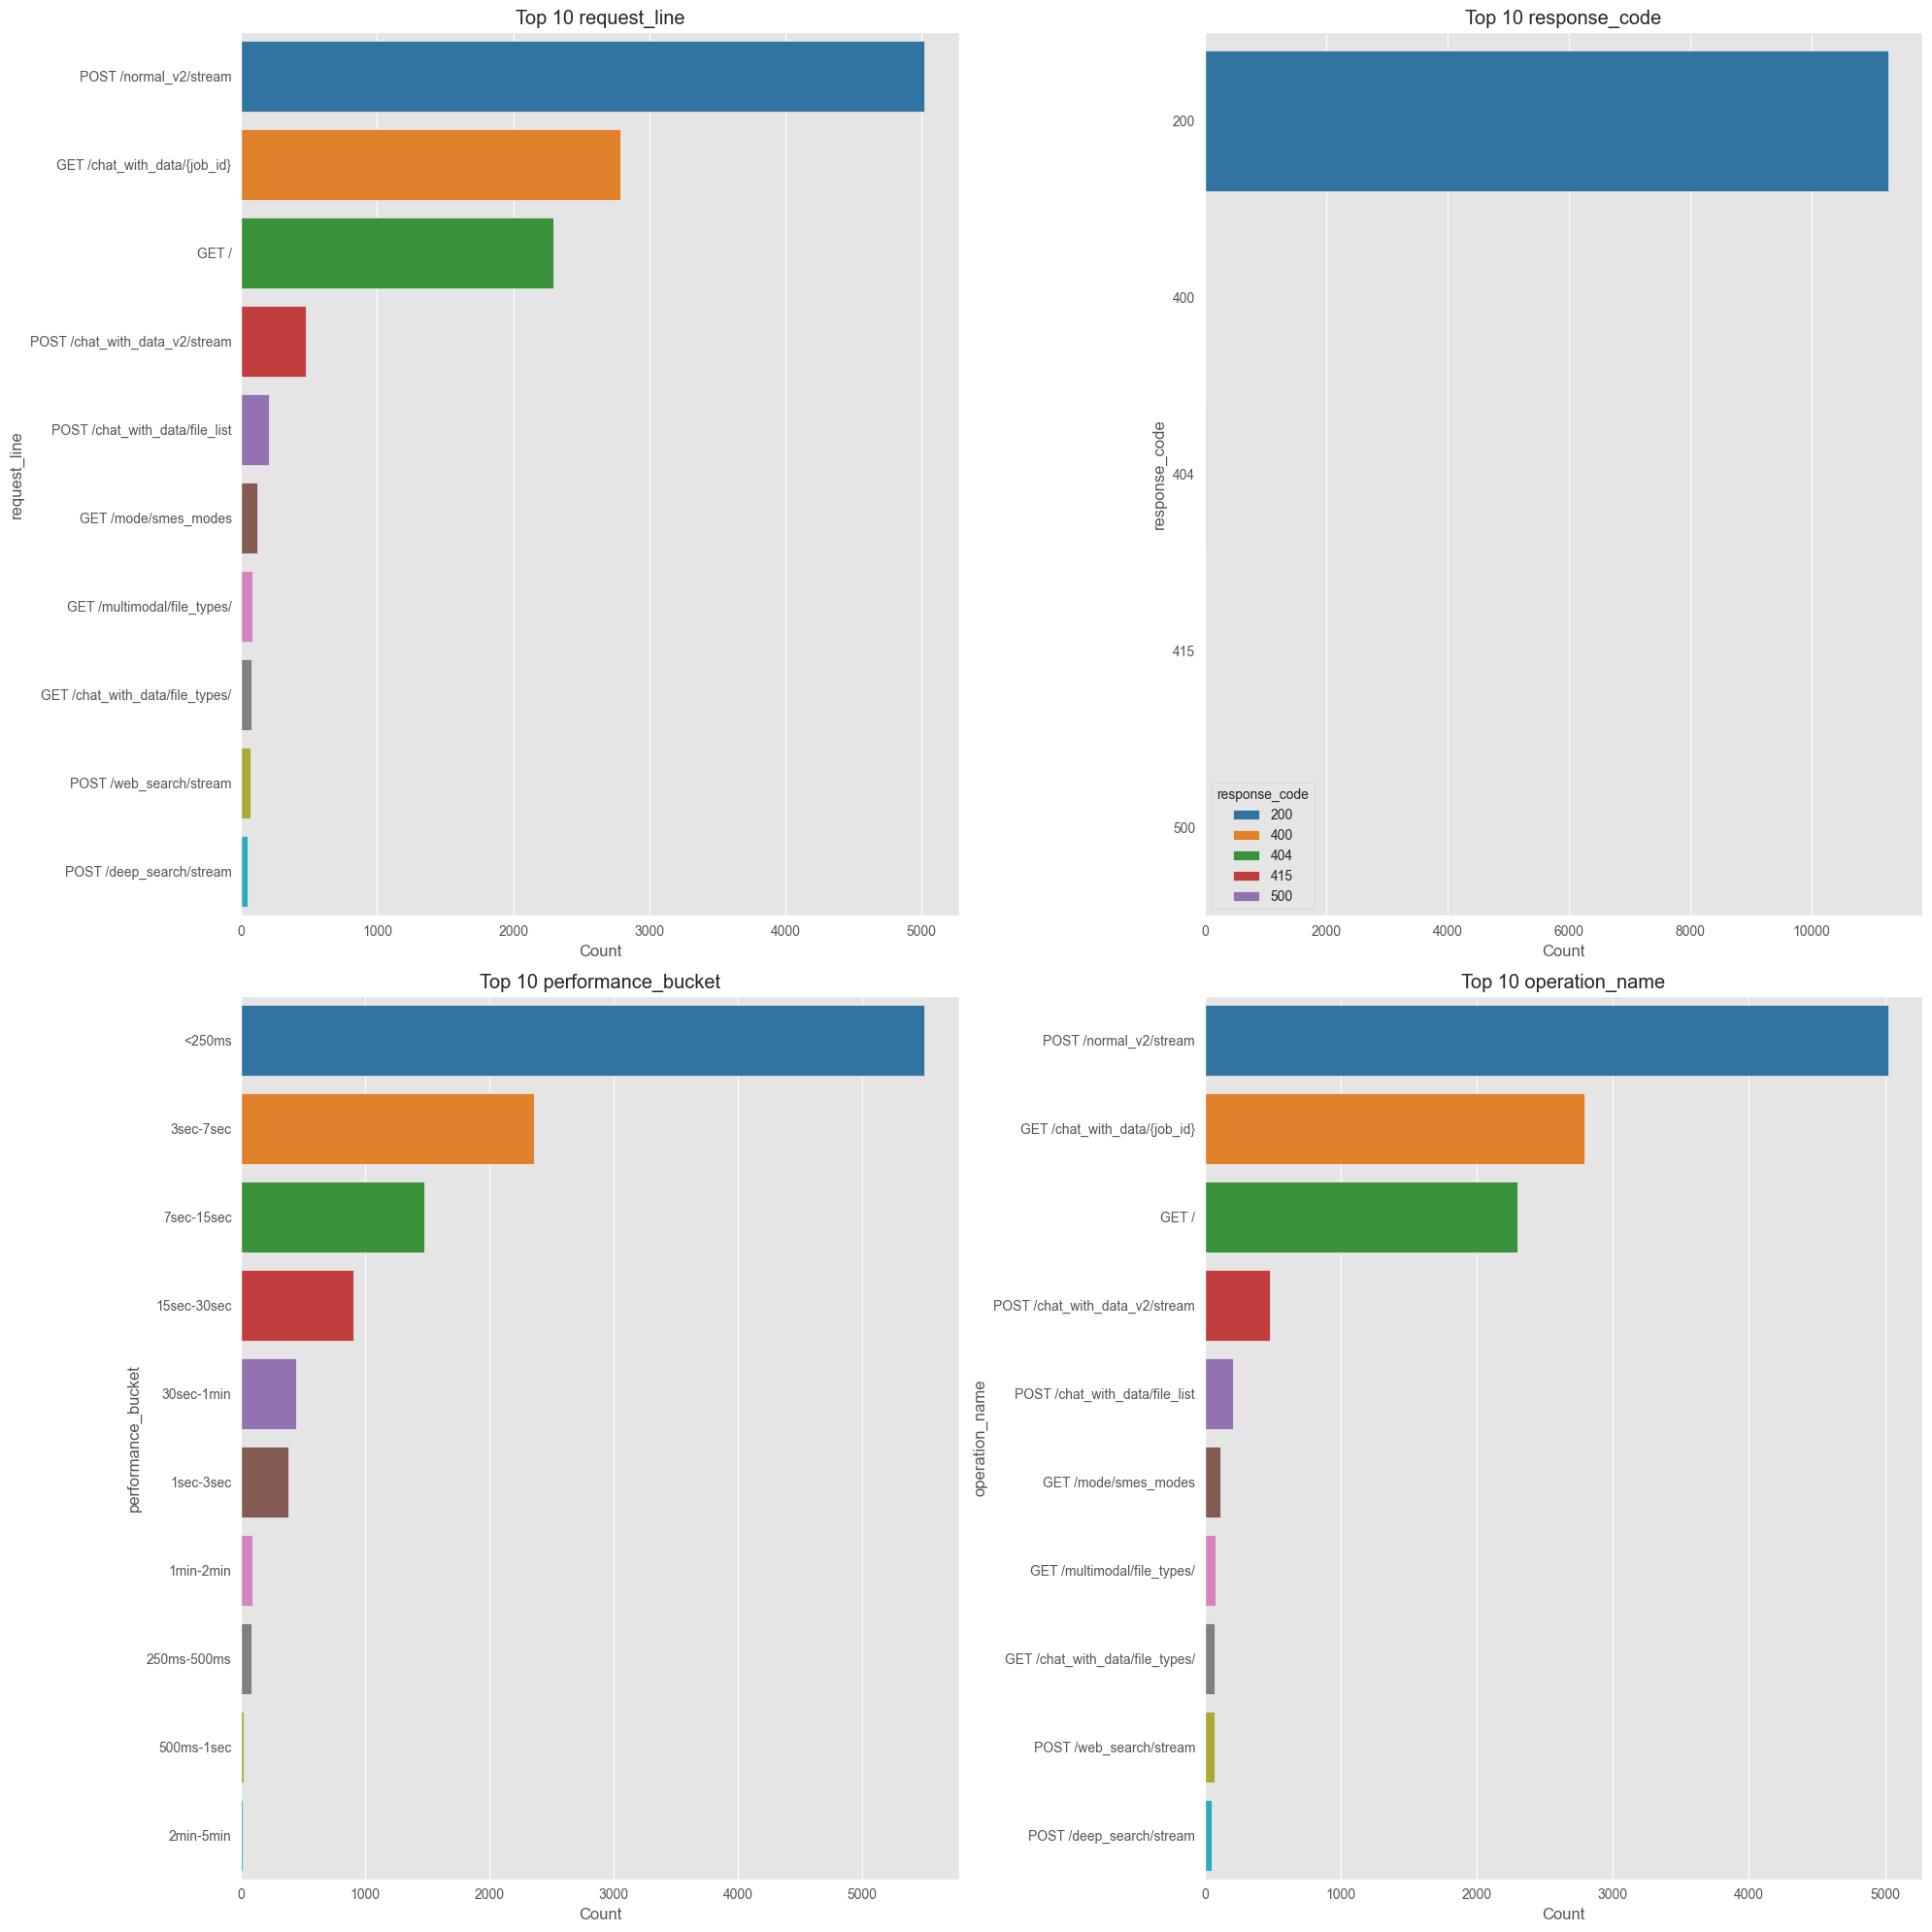

In [222]:
cat_cols = [col for col in df.columns if col not in ['duration_ms', 'timestamp']]
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(cat_cols):
    top_counts = df[col].value_counts().head(10)
    palette = sns.color_palette("tab10", n_colors=len(top_counts))
    sns.barplot(
        x=top_counts.values,
        y=top_counts.index,
        orient='h',
        ax=axes[i],
        hue=top_counts.index,
        palette=palette
    )
    axes[i].set_title(f'Top 10 {col}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(col)

plt.tight_layout()